<a href="https://colab.research.google.com/github/KillerStrike17/Deep-Learning-for-Vision-Using-Tensorflow-Keras/blob/master/6.%20Types-of-Convolutions/Types_of_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Loadinng all the required libraries
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
#Importing the database
from keras.datasets import cifar10
#splitting the database
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
#Storing the training dataset details in variables
num_train,  img_rows, img_cols,img_channels, =  train_features.shape
print("No of training dataset:- ",num_train)
print("No of rows:- ",img_rows)
print("No of columns:- ",img_cols)
print("No of channels:- ",img_channels)
#Storing the testing dataset details in variables
num_test, _, _, _ =  test_features.shape
#Stroing the total class of dataset in num_classes variable
num_classes = len(np.unique(train_labels))
print("Total Classes:- ", num_classes)
print("Total Classes:- ", train_features.shape)
print("Total Classes:- ", train_labels.shape)

No of training dataset:-  50000
No of rows:-  32
No of columns:-  32
No of channels:-  3
Total Classes:-  10
Total Classes:-  (50000, 32, 32, 3)
Total Classes:-  (50000, 1)


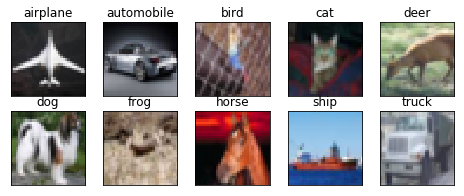

In [0]:
#class_names of the dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
#loop to display a sample image of each channel
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot graphs of accuracy and loss
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#Function to calculate accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#converting the pixel in range 0-1
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
#Define the model
model = Model()

#normal Convolution
visible = Input(shape =(32, 32, 3))
conv1 = Convolution2D(30, 3, 3, border_mode='same', activation = 'relu')(visible)
drop1 = Dropout(0.25)(conv1)

#Spatially Separable Convolution
hidden1 = Convolution2D(60, (3, 1) ,border_mode='same', activation = 'relu')(drop1)
hidden2 = Convolution2D(60, (1, 3) ,border_mode='same', activation = 'relu')(hidden1)
drop2 = Dropout(0.25)(hidden2)

#Transition Block
pool1 = MaxPooling2D(pool_size=(2, 2))(drop2)
pointwise1 = Convolution2D(30, 1, 1, border_mode='same', activation = 'relu')(pool1)

#Depth Wise Separable Convolution
hidden3 = SeparableConv2D(30, 3, 3 , activation = 'relu')(pointwise1)
drop3 = Dropout(0.25)(hidden3)

#Group Convolution (3x3) & (5x5)
group1 = Convolution2D(60, 3, 3, border_mode='same', activation = 'relu')(drop3)
group2 = Convolution2D(60, 5, 5, border_mode='same', activation = 'relu')(drop3)
merge = concatenate([group1, group2])
drop4 = Dropout(0.25)(merge)

#Transition Block
pool2 = MaxPooling2D(pool_size=(2, 2))(drop4)
pointwise2 = Convolution2D(30, 1, 1, border_mode='same', activation = 'relu')(pool2)

#Group Convolution with dilations
group3 = Convolution2D(60, 3, 3, border_mode='same', activation = 'relu')(pointwise2)
group4 = Convolution2D(60, 3, 3, border_mode='same', activation = 'relu',dilation_rate=2)(pointwise2)
merge2 = concatenate([group3, group4])
drop5 = Dropout(0.25)(merge2)

#Output Layer
hidden4 = Convolution2D(10, 7)(drop5)
hidden5 = Flatten()(hidden4)
output = Activation('softmax')(hidden5)

model = Model(inputs=visible, outputs=output)

# summarize layers
print(model.summary())
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (3, 3), activation="relu", padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(60, (3, 1), activation="relu", padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(60, (1, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(30, (1, 1), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(30

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 32, 32, 30)   840         input_15[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 30)   0           conv2d_149[0][0]                 
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 32, 32, 60)   5460        dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_151

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 15s 37ms/step - loss: 1.7245 - acc: 0.3671 - val_loss: 1.7958 - val_acc: 0.3702
Epoch 2/50
390/390 [==============================] - 13s 34ms/step - loss: 1.3308 - acc: 0.5190 - val_loss: 1.3805 - val_acc: 0.5091
Epoch 3/50
390/390 [==============================] - 13s 34ms/step - loss: 1.1633 - acc: 0.5865 - val_loss: 1.2193 - val_acc: 0.5741
Epoch 4/50
390/390 [==============================] - 13s 34ms/step - loss: 1.0314 - acc: 0.6367 - val_loss: 1.1208 - val_acc: 0.6119
Epoch 5/50
390/390 [==============================] - 13s 34ms/step - loss: 0.9415 - acc: 0.6694 - val_loss: 1.1307 - val_acc: 0.6066
Epoch 6/50
390/390 [==============================] - 13s 34ms/step - loss: 0.8674 - acc: 0.6950 - val_loss: 0.9751 - val_acc: 0.6659
Epoch 7/50
390/390 [==============================] - 13s 34ms/step - loss: 0.8099 - acc: 0.7149 - val_loss: 0.9939 - val_acc: 0.6539
Epoch 8/50
390/390 [==============================] - 13s 34ms

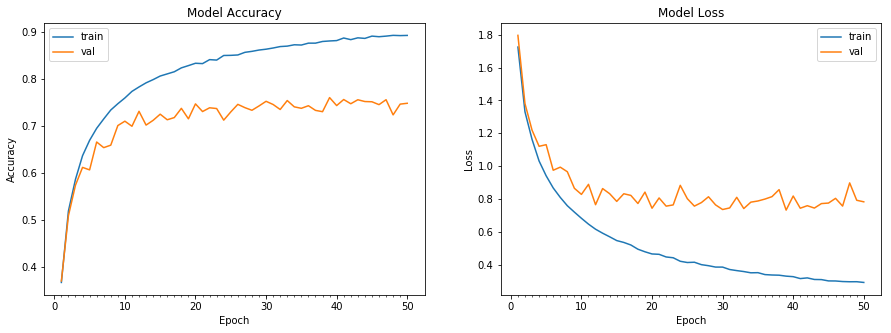

Accuracy on test data is: 74.84


In [0]:
# Training the developed model over the dataset
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))